In [1]:
model_path="./checkpoint/model_120001.pt"
data_path="./celeba/img_align_celeba"

In [2]:
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi

import argparse

import torch
from torch import nn, optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

from model import Glow
from train import parser, calc_z_shapes

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
args = parser.parse_args([data_path,])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(args)

Namespace(affine=False, batch=16, img_size=64, iter=200000, lr=0.0001, n_bits=5, n_block=4, n_flow=32, n_sample=20, no_lu=False, path='./celeba/img_align_celeba', temp=0.7)


In [4]:
model_single = Glow(
        3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
    )
model = nn.DataParallel(model_single, device_ids=[0])
# model = model_single
model = model.to(device)

/home/george/Projects/cognitive/proj/glow-pytorch/model.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  w_s = torch.from_numpy(w_s)


In [5]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
torch.manual_seed(7)
z_sample = []
z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
for z in z_shapes:
    z_new = torch.randn(args.n_sample, *z) * args.temp
    z_sample.append(z_new.to(device))

In [7]:
imgs = model_single.reverse(z_sample).cpu().data

In [8]:
%matplotlib inline
def show(img, fig_size=(12,8)):
    npimg = img.numpy()
    fig = plt.figure(figsize=fig_size, dpi=100) 
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

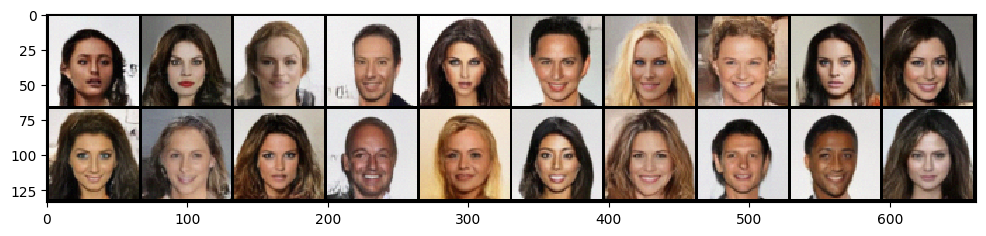

In [9]:
show(make_grid(imgs, normalize=True,
                        nrow=10,
                        range=(-0.5, 0.5),))

In [10]:
def index(sample, indices):
    return [z[indices] for z in sample]

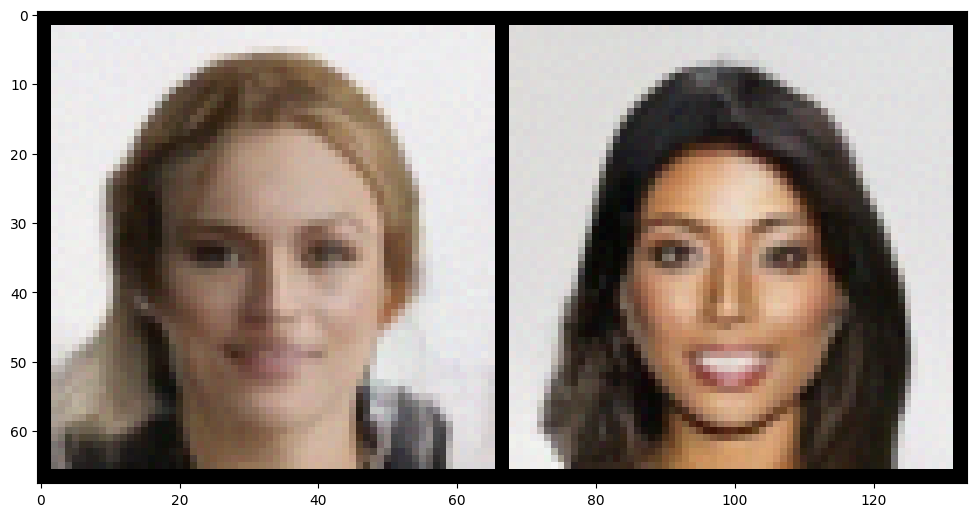

In [33]:
sample_id1, sample_id2 = 2, 15#4,18
imgs2 = model_single.reverse(index(z_sample, slice(sample_id1,sample_id2+1,sample_id2-sample_id1))).cpu().data
show(make_grid(imgs2, normalize=True,
                        nrow=10,
                        range=(-0.5, 0.5),))

In [34]:
# from PIL import Image
# img_pil1 = Image.open("../imgs/rachel.jpg").convert('RGB')
# # img_pil2 = Image.open("isabelle.png").convert('RGB')
# image_size = (64,64)
# transform = transforms.Compose(
#     [
#         transforms.Resize(image_size),
#         transforms.CenterCrop(image_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]
# )
# im1, im2 = imgs[sample_id1].numpy() + 0.5, transform(img_pil1).numpy()
im1, im2 = imgs[sample_id1].numpy() + 0.5, imgs[sample_id2].numpy() + 0.5

In [25]:
from morphing import *

In [35]:
## args
Generator = model_single
Generator_args = args
epsilon = 20.0
L = 9
dcgan_size = 64

## code 
# im1, im2 = imgs[sample_id1].numpy() + 0.5, imgs[sample_id2].numpy() + 0.5
img_size = im1.shape[1:]
im1, im2 = (I.reshape(3,-1,1) for I in (im1, im2))

print("Preparing transportation cost matrix...")
C = generate_metric(img_size)
Q = np.concatenate([im1, im2], axis=-1)
Q, max_val, Q_counts = preprocess_Q(Q)
out_ours = []
out_GAN = []
out_OT = []

print("Computing transportation plan...")
for dim in range(3):
    print(f"Color space {dim+1}/3")
    out_OT.append([])
    P = sinkhorn(Q[dim,:,0], Q[dim,:,1], C, img_size[0], img_size[1], epsilon)
    for t in tqdm(np.linspace(0,1,L)):
        out_OT[-1].append(max_val - generate_interpolation(img_size[0],img_size[1],P,t)*((1-t)*Q_counts[dim,0,0] + t*Q_counts[dim,0,1]))
out_OT = [np.stack(im_channels, axis=0) for im_channels in zip(*out_OT)]

Preparing transportation cost matrix...
Computing transportation plan...
Color space 1/3
Iteration 50. Sinkhorn convergence: 2.66E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 3.34E-02 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 1.53E-02 ( > 1e-07)
Iteration 200. Sinkhorn convergence: 9.29E-09 (Converged!)



Color space 2/3
Iteration 50. Sinkhorn convergence: 9.46E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 3.19E-07 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 6.30E-09 (Converged!)



Color space 3/3
Iteration 50. Sinkhorn convergence: 1.19E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 1.09E-07 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 1.46E-09 (Converged!)


In [15]:
# def project_on_generator(G: nn.Module, args: Namespace,
#                          target_image: np.ndarray, dcgan_img_size: int=64,  eta: float=1.0, eps: float=0.1,
#                          ) -> Tuple[np.ndarray, torch.Tensor]:
#     n_bins = 2.0 ** args.n_bits
    
#     # target_image (3,64,64)
#     tensor_image = torch.Tensor(target_image.clip(0, 1)).cuda().reshape(1,3,dcgan_img_size,dcgan_img_size)
#     tensor_image = tensor_image.type(dtype=torch.float32)    

#     tensor_image = tensor_image * 255 # 0~1 -> 0~255

#     if args.n_bits < 8:
#         tensor_image = torch.floor(tensor_image / 2 ** (8 - args.n_bits))
    
#     image = tensor_image        
#     image = image / n_bins - 0.5 # -0.5 ~ 0.5

#     # use grad
#     image.requires_grad = True
    
# #     for i in range(iters):
#     log_p = None
#     while (log_p is None) or (last_log_p is None) or (abs(last_log_p - log_p) > eps):
#         last_log_p = log_p
#         image.retain_grad()
        
#         log_p, logdet, z_outs = G(image) #+ torch.rand_like(image) / n_bins)

#         logdet = logdet.mean()

#         loss, log_p, log_det = calc_loss(log_p, logdet, args.img_size, n_bins)

#         G.zero_grad()
#         if image.grad is not None:
#             image.grad.detach_()
#             image.grad.zero_()

#         loss.backward(retain_graph=True)
#         cur_grad = image.grad
#         assert (cur_grad!=0).any()
#         image = image - eta*cur_grad
        
#         if last_log_p is None:
#             print(f"init, logp={log_p}")
#     print(f"converged, logp={log_p}")        
        
#     pix_outputs = image.detach().cpu().numpy()    
#     pix_outputs = pix_outputs.clip(-0.5, 0.5) + 0.5
#     return pix_outputs.squeeze(), log_p, z_outs

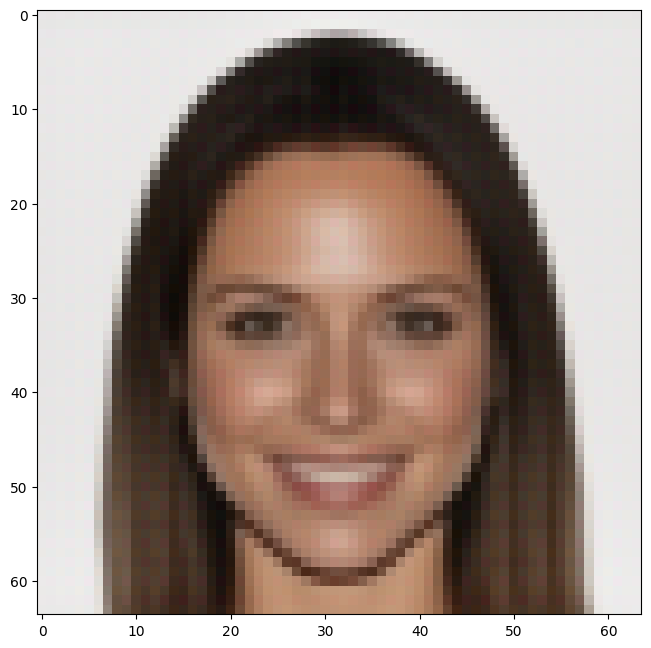

In [16]:
z_0 = []
for z in z_shapes:
    z_new = torch.zeros((1, *z), requires_grad=True) #torch.randn(args.n_sample, *z) * args.temp
    z_0.append(z_new.to(device))
fake = model_single.reverse(z_0, reconstruct=False)
im = fake.detach().cpu().numpy()
im = im.clip(-0.5, 0.5) + 0.5
show(torch.Tensor(im).reshape(3,*img_size))

In [28]:
from typing import Callable, List, Tuple
from tqdm.auto import tqdm
def project_on_generator(G: nn.Module, args: Namespace,
                        target_images: np.ndarray, dcgan_img_size: int=64,  
                        iters:int=10, eta: float=1.0, eps: float=0.1,
                        loss_fn: Callable=nn.L1Loss(),
                        z_init: List=None,
                        reconstruct: bool=False,
                        **optim_args
                        ) -> Tuple[np.ndarray, torch.Tensor]:
    
    tensor_image = torch.Tensor(target_images).cuda().reshape(-1,3,dcgan_img_size,dcgan_img_size)
    tensor_image = tensor_image.type(dtype=torch.float32)
    tensor_image = tensor_image - 0.5
    
    n_samples = tensor_image.size(0)
        
    if z_init is not None:
        z_0 = z_init
    else:
        z_0 = []
        for z in z_shapes:
            #z_new = torch.zeros((n_samples, *z), requires_grad=True)
            z_new = torch.zeros((n_samples, *z))
            z_0.append(z_new.to(device))
    
    # use optim LBFGS
    optimizer = torch.optim.AdamW(
        [z.requires_grad_() for z in z_0],
        lr=eta,
        **optim_args #weight_decay=1e-2,
    )
            
    loss = None
    pbar = tqdm(range(iters), total=iters)
    err = 10000
    for _ in pbar:
        if (loss != None and last_loss != None) and (err <= eps):
            print(f"converged loss\t{loss}")
            break
        
        last_loss = loss
        
#         for z in z_0:
#             z.retain_grad()
#             if z.grad is not None:
#                 z.grad.detach_()
#                 z.grad.zero_()
        
#         G.zero_grad()
        optimizer.zero_grad()

        fake = G.reverse(z_0, reconstruct=reconstruct)
        
        loss = loss_fn(fake, tensor_image)
        
        loss.backward(retain_graph=True)
        
#         for z in z_0:
#             cur_grad = z.grad
#             assert (cur_grad!=0).any()
#             z.add_(-eta*cur_grad)
        
        optimizer.step()
        
        
        if last_loss is None:
            print(f"initial loss:\t{loss}")
        else:
            err = abs(last_loss.item() - loss.item())
        pbar.set_postfix(loss=loss.item(), err=err)
          
        
    pix_outputs = fake.detach().cpu().numpy()    
    pix_outputs = pix_outputs.clip(-0.5, 0.5) + 0.5
    return pix_outputs, None, z_0 #.squeeze(), None, z_0

In [29]:

# print("Computing GAN projections...")
# # Project OT results on GAN
# model_single.eval()
# out_ours, _, z_0 = project_on_generator(
#     model_single, Generator_args, 
#     np.asarray(out_OT), 
#     dcgan_img_size=dcgan_size,
#     iters=50, 
#     eta=0.01, #7.5, 
#     eps=1e-5,
#     loss_fn=nn.L1Loss(),
#     reconstruct=False
# )

In [36]:
noise1 = [n[sample_id1:sample_id1+1].cuda() for n in z_sample]
noise2 = [n[sample_id2:sample_id2+1].cuda() for n in z_sample]
z_init = [ 
    torch.cat(
        [ (1-t)*a + t*b  for t in torch.linspace(0,1,L)],
        dim=0
    )
    for a,b in zip(noise1, noise2)
]
out_ours, _, z_0 = project_on_generator(
    model_single, Generator_args, 
    np.asarray(out_OT), 
    dcgan_img_size=dcgan_size,
    iters=8, 
    eta=0.01, #7.5, 
    eps=1e-5,
    loss_fn=nn.L1Loss(),
    z_init=z_init,
    reconstruct=True
)

initial loss:	0.08345456421375275



In [38]:
# Linearly interpolate GAN's latent space
noise1 = [n[sample_id1:sample_id1+1].cuda() for n in z_sample]
noise2 = [n[sample_id2:sample_id2+1].cuda() for n in z_sample]
# noise1 = [n[0:1].cuda() for n in z_0]
# noise2 = [n[-1:].cuda() for n in z_0]
# noise1 = [n[0:1].cuda() for n in z_0]
# tensor_image = torch.Tensor(out_OT[-1:]).cuda().reshape(-1,3,64,64)
# tensor_image = tensor_image.type(dtype=torch.float32)
# tensor_image = tensor_image - 0.5
# *_, noise2 = model_single(tensor_image)

out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = [(1-t)*a + t*b for a,b in zip(noise1, noise2)]
    GAN_interp_noises.append(z_inter)
    GAN_image = model_single.reverse(z_inter, reconstruct=True).cpu().data

    GAN_image = GAN_image.numpy().clip(-0.5, 0.5) + 0.5
    out_GAN.append(GAN_image)

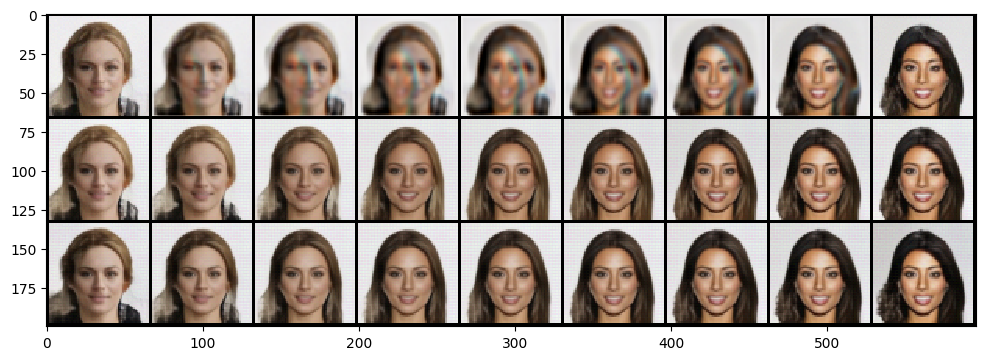

In [39]:
final_OT = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_OT])
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), 
        normalize=True,
        nrow=L,
        range=(0.,1.)))
#         range=(-0.5,0.5)))

In [22]:
raise

RuntimeError: No active exception to reraise

In [ ]:
show(tensor_image.cpu().reshape(3,*img_size)+0.5)

In [ ]:
tensor_image = torch.Tensor(out_OT[-1:]).cuda().reshape(-1,3,64,64) - 0.5
tensor_image.shape

In [ ]:
iters = 75
eta = 0.2
eps = 1e-5
loss_fn = nn.L1Loss()

n_samples = tensor_image.size(0)

z_0 = []
for z in z_shapes:
    #z_new = torch.zeros((n_samples, *z), requires_grad=True)
    z_new = torch.zeros((n_samples, *z))
    z_0.append(z_new.to(device))

# use optim LBFGS
optimizer = torch.optim.AdamW(
    [z.requires_grad_() for z in z_0],
    lr=eta,
    weight_decay=1e-2,
)


pbar = tqdm(range(iters), total=iters)
pix_outputs = []
for _ in pbar:
    optimizer.zero_grad()

    fake = model_single.reverse(z_0, reconstruct=False)

    loss = loss_fn(fake, tensor_image)

    loss.backward(retain_graph=True)

    optimizer.step()

    pbar.set_postfix(loss=loss.item())
    
    pix_output = fake.detach().cpu().numpy()
    pix_output = pix_output.clip(-0.5, 0.5) + 0.5
    pix_outputs.append(pix_output)

In [ ]:
final_trans = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in pix_outputs[::10]])
show(make_grid(final_trans, 
        normalize=True,
        nrow=len(final_trans),
        range=(0.,1.)))
#         range=(-0.5,0.5)))

In [ ]:
class myloss2(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.L1Loss(reduction='none')
        
    def forward(self, out, target):
        loss = self.loss(out, target)
        mask = target.ne(0).type_as(loss)
        return (loss*mask).mean()

In [ ]:
from PIL import Image
img_pil1 = Image.open("../imgs/marvin.png").convert('RGB')
# img_pil2 = Image.open("isabelle.png").convert('RGB')
image_size = (64,64)
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing(p=1),
    ]
)
test1 = transform(img_pil1).numpy()
out1, _, _ = project_on_generator(
    model_single, Generator_args, 
    np.asarray([test1]), 
    dcgan_img_size=dcgan_size,
    iters=50, 
    eta=0.1, #7.5, 
    eps=1e-5,
    loss_fn=myloss2() #myloss(),
)
final_test = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in (test1, out1[0])])
show(make_grid(final_test, 
        normalize=True,
        nrow=L,
        range=(0.,1.)))
#         range=(-0.5,0.5)))

In [ ]:
def rangestat(m):
    print(m.min(),
          m.max(),
          m.mean(),
          m.std(),)

In [ ]:
def get_latent(G: nn.Module, args: Namespace,
                         target_image: np.ndarray, dcgan_img_size: int=64,  eta: float=1.0, eps: float=0.1,
                         ) -> Tuple[np.ndarray, torch.Tensor]:
    n_bins = 2.0 ** args.n_bits
    
    # target_image (3,64,64)
    tensor_image = torch.Tensor(target_image.clip(0, 1)).cuda().reshape(1,3,dcgan_img_size,dcgan_img_size)
    tensor_image = tensor_image.type(dtype=torch.float32)    

    tensor_image = tensor_image * 255 # 0~1 -> 0~255

    if args.n_bits < 8:
        tensor_image = torch.floor(tensor_image / 2 ** (8 - args.n_bits))
    
    image = tensor_image        
    image = image / n_bins - 0.5 # -0.5 ~ 0.5
        
    log_p, logdet, z_outs = G(image)
    return z_outs, image.cpu() + 0.5 # quant

In [ ]:
from PIL import Image
img_pil1 = Image.open("marvin.png").convert('RGB')
# img_pil2 = Image.open("isabelle.png").convert('RGB')
image_size = (64,64)
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test1 = transform(img_pil1).numpy()
# test2 = transform(img_pil2).numpy()
test2 = out_OT[0]
# noise2 = [n[0:1].cuda() for n in z_sample]

noise1, quant1 = get_latent(Generator, Generator_args, test1, dcgan_img_size=dcgan_size, eta=0.01, eps=0.1)
noise2, quant2 = get_latent(Generator, Generator_args, test2, dcgan_img_size=dcgan_size, eta=0.01, eps=0.1)


# Linearly interpolate GAN's latent space
out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = [(1-t)*a + t*b for a,b in zip(noise1, noise2)]
    GAN_interp_noises.append(z_inter)
    GAN_image = model_single.reverse(z_inter, reconstruct=True).cpu().data

    GAN_image = GAN_image.numpy().clip(-0.5, 0.5) + 0.5
    out_GAN.append(GAN_image)

final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_GAN,], dim=0), 
        normalize=True,
        nrow=L,
        range=(0.,1.)))

In [ ]:
show(make_grid(torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in (test1, quant1, test2, quant2)]), 
        normalize=True,
        nrow=L,
        range=(0.,1.)))